# Yolo 8 food detection

In [1]:
# !pip install ultralytics

In [20]:
!pip install pyYAML

In [25]:
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import yaml

In [23]:
# Load a pretrained YOLO model
model = YOLO("yolov8n.pt")

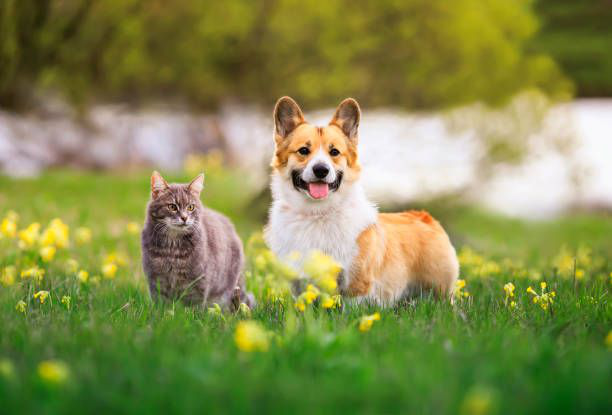

In [10]:
cat_dog = Image.open("cat_dog.jpg")
# cat_dog = cat_dog.resize((624,416))
cat_dog = np.asarray(cat_dog)
Image.fromarray(cat_dog)

In [4]:
cat_dog.shape

(415, 612, 3)

In [5]:
result = model.predict(cat_dog)


0: 448x640 1 dog, 1 sheep, 1 bear, 411.6ms
Speed: 21.1ms preprocess, 411.6ms inference, 22.5ms postprocess per image at shape (1, 3, 448, 640)


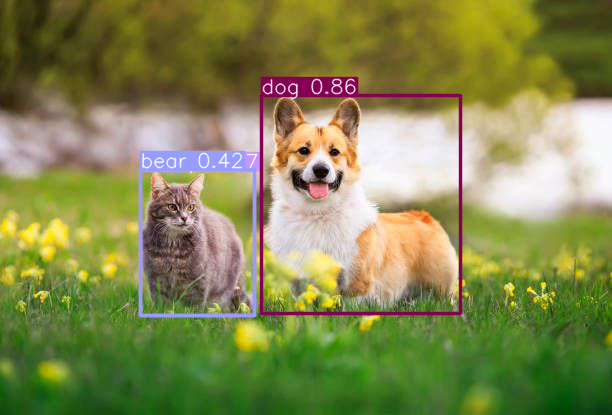

In [6]:
Image.fromarray(result[0].plot())

In [7]:
names = pd.read_csv("oidv7-class-descriptions-boxable.csv")

In [8]:
translate_dict = {}
for row in names.iterrows():
    translate_dict[row[1]["LabelName"]] = row[1]["DisplayName"]

In [11]:
annotations = pd.read_csv("oidv6-train-annotations-bbox.csv")

In [12]:
annotations["DisplayName"] = annotations["LabelName"].map(translate_dict)

In [13]:
annotations

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y,DisplayName
0,000002b66c9c498e,xclick,/m/01g317,1,0.012500,0.195312,0.148438,0.587500,0,1,...,0,0.148438,0.012500,0.059375,0.195312,0.148438,0.357812,0.587500,0.325000,Person
1,000002b66c9c498e,xclick,/m/01g317,1,0.025000,0.276563,0.714063,0.948438,0,1,...,0,0.025000,0.248438,0.276563,0.214062,0.914062,0.714063,0.782813,0.948438,Person
2,000002b66c9c498e,xclick,/m/01g317,1,0.151562,0.310937,0.198437,0.590625,1,0,...,0,0.243750,0.151562,0.310937,0.262500,0.198437,0.434375,0.507812,0.590625,Person
3,000002b66c9c498e,xclick,/m/01g317,1,0.256250,0.429688,0.651563,0.925000,1,0,...,0,0.315625,0.429688,0.256250,0.423438,0.651563,0.921875,0.826562,0.925000,Person
4,000002b66c9c498e,xclick,/m/01g317,1,0.257812,0.346875,0.235938,0.385938,1,0,...,0,0.317188,0.257812,0.346875,0.307812,0.235938,0.289062,0.348438,0.385938,Person
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14610224,fffffdaec951185d,xclick,/m/0dzct,1,0.445625,0.672500,0.154784,0.200750,1,0,...,0,0.510000,0.445625,0.538125,0.672500,0.154784,0.168856,0.200750,0.176360,Human face
14610225,fffffdaec951185d,xclick,/m/0dzct,1,0.695625,0.786250,0.118199,0.297373,0,0,...,0,0.725000,0.748125,0.695625,0.786250,0.118199,0.297373,0.233583,0.207317,Human face
14610226,fffffdaec951185d,xclick,/m/0dzct,1,0.788750,0.835000,0.198874,0.272045,1,0,...,0,0.814375,0.814375,0.788750,0.835000,0.198874,0.272045,0.245779,0.247655,Human face
14610227,fffffdaec951185d,xclick,/m/0dzct,1,0.796875,0.951875,0.156660,0.205441,1,0,...,0,0.868750,0.796875,0.951875,0.942500,0.156660,0.176360,0.189493,0.205441,Human face


In [14]:
foods = annotations[annotations["DisplayName"] == "Food"]

In [16]:
food_images = foods["ImageID"].drop_duplicates()[:2000]

In [17]:
food_images

181        000032046c3f8371
760        00006c07d2b033d1
2047       00011aec5d7324f4
3219       0001d1b33deff2d3
3310       0001f15e0ac6c918
                 ...       
1251903    12b7268d1c912631
1252491    12b8f4a0f47afa58
1252523    12b8f6d2389a950a
1252752    12b9ee686e89580e
1252808    12ba0a52096bcf21
Name: ImageID, Length: 2000, dtype: object

In [18]:
with open("to_download.txt", "w", encoding="utf-8") as to_download:
    for image in food_images:
        to_download.write("train/" + image+ "\n")

In [19]:
# !python downloader.py to_download.txt --download_folder=image_data --num_processes=5